# Combination of Over- and Under-sampling/ Hybrid Methods

There are two ready-to-use classes imbalanced-learn implements for combining over- and under-sampling methods are SMOTETomek and SMOTEENN. Short demo can be found [here](https://eqibuana.medium.com/how-to-deal-with-imbalanced-data-in-classification-tasks-1046e5be0e0)

# Data

In [1]:
# loading necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('thl_recoded.csv')
data.head()

,kannabis,alcohol_use,nuuska,cigarette,e_cigarette,prob_country,prob_resident,risk_of_use,risk_of_try,cannabis_access,...,household_2.0,household_3.0,education_2.0,education_3.0,education_4.0,violence_treat_2.0,violence_treat_3.0,drug_punishment_2.0,drug_punishment_3.0,drug_punishment_4.0
0,0.0,3.0,1.0,1.0,1.0,3.0,2.0,24.0,13.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,1.0,1.0,1.0,1.0,3.0,2.0,23.0,17.0,3.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,5.0,1.0,2.0,1.0,4.0,3.0,24.0,18.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1.0,7.0,2.0,2.0,1.0,3.0,2.0,22.0,12.0,3.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,5.0,1.0,1.0,1.0,3.0,2.0,24.0,16.0,2.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [3]:
 # Kannabis use
data['kannabis'].value_counts(normalize= True)

0.0    0.914525
1.0    0.085475
Name: kannabis, dtype: float64

In [4]:
from sklearn.model_selection import train_test_split

X, y = data.iloc[:, 1:].values, data.iloc[:, 0].values

# Model 1: sampling_strategy='majority'

In [5]:
# resample by adding samples to minority class using SMOTE
from collections import Counter
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

# 'majority': resample only the majority class;
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_oversamp, Y_over_samp = resample.fit_resample(X, y)



#split data train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_oversamp,
                                                    Y_over_samp,
                                                    test_size=0.3,
                                                    random_state = 10)



print(f"Class counts after resampling {Counter( Y_over_samp)}")

Class counts after resampling Counter({0.0: 2953, 1.0: 2953})


In [6]:
# RFECF model 
def refcv_model(X_train, y_train, estimator, model, n_splits,n_repeat):
    from sklearn.pipeline import Pipeline
    from sklearn.feature_selection import RFECV
    from sklearn.model_selection import RepeatedStratifiedKFold
    from sklearn.model_selection import cross_val_score
    from sklearn.feature_selection import RFECV
    
    rfecv = RFECV(estimator=estimator)
   
    pipeline = Pipeline([('Feature Selection', rfecv), ('Model', model)])
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=92116)
    n_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    np.mean(n_scores)
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)


    
    print('Optimal number of features : %d' % rfecv.n_features_)
    
    rfecv.support_rfecv_df = pd.DataFrame(rfecv.ranking_,index=data.columns[1:],columns=['Rank']).sort_values(by='Rank',ascending=True)
    

    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,6))
    plt.xlabel('Number of features selected')
    plt.ylabel('Cross validation score (nb of correct classifications)')
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    # list of features for further use
    rfecv.support_rfecv_df = pd.DataFrame(rfecv.ranking_,index=data.columns[1:],columns=['Rank']).sort_values(by='Rank',ascending=True)

    dt_columns = rfecv.support_rfecv_df [rfecv.support_rfecv_df ['Rank']==1].reset_index()
    dt_columns = list(np.array(dt_columns['index']))
    dt_columns 
    
    return y_pred, dt_columns, rfecv.support_rfecv_df, plt.show(),
    
    
    

In [7]:
# results
def plot_results(y_pred):
    from sklearn import metrics
    from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import accuracy_score

    print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
    print('Precision:', np.round(metrics.precision_score(y_test, y_pred,average='weighted'),4))
    print('Recall:', np.round(metrics.recall_score(y_test, y_pred,
                                               average='weighted'),4))
    print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred,
                                               average='weighted'),4))
    print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
    print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test, y_pred),4)) 

    from sklearn.metrics import roc_auc_score
    print("roc_auc_score:", roc_auc_score(y_test, y_pred, average=None))

    print('\t\tClassification Report:\n', metrics.classification_report(y_pred,y_test))


    from sklearn.metrics import confusion_matrix
    print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))


    #Plot Confusion Matrix
    from sklearn.metrics import confusion_matrix
    from io import BytesIO #neded for plot
    import seaborn as sns; sns.set()
    import matplotlib.pyplot as plt

    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)


    plt.xlabel('true label')
    plt.ylabel('predicted label');

    plt.savefig("Confusion.jpg")
    # Save SVG in a fake file object.
    f = BytesIO()
    plt.savefig(f, format="svg")

## 1.1. Gradient Boosting Classifier

Optimal number of features : 42


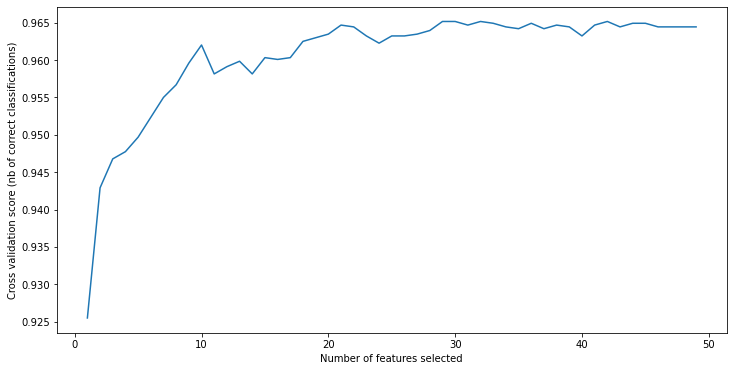

Accuracy: 0.9628
Precision: 0.9628
Recall: 0.9628
F1 Score: 0.9628
Cohen Kappa Score: 0.9255
Matthews Corrcoef: 0.9255
roc_auc_score: 0.9626697524570775
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.96      0.96       910
         1.0       0.96      0.97      0.96       862

    accuracy                           0.96      1772
   macro avg       0.96      0.96      0.96      1772
weighted avg       0.96      0.96      0.96      1772

Confusion Matrix:
 [[874  30]
 [ 36 832]]


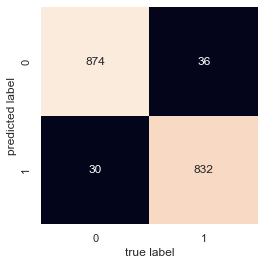

In [8]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

estimator = GradientBoostingClassifier()
model = GradientBoostingClassifier()
n_splits = 5
n_repeats = 5

gbc_model = refcv_model(X_train, y_train, estimator, model, n_splits, n_repeats)
plot_results(gbc_model[0])

In [9]:
# list of features
gbc_model[1]

['alcohol_use',
 'drug_punishment_3.0',
 'free_offer_1',
 'purchase_offer_1',
 'alcohol_hp_1',
 'drug_hp_1',
 'medicine_hp_1',
 'poly_hp_1',
 'employment_1',
 'rural_1',
 'gender_2',
 'age_bins_(54, 70]',
 'household_2.0',
 'household_3.0',
 'education_3.0',
 'education_4.0',
 'violence_treat_2.0',
 'violence_treat_3.0',
 'drug_punishment_2.0',
 'age_bins_(24, 34]',
 'small_city_1',
 'drug_user_friend_1',
 'bigger_city_1',
 'nuuska',
 'cigarette',
 'e_cigarette',
 'prob_country',
 'prob_resident',
 'risk_of_use',
 'risk_of_try',
 'cannabis_access',
 'midsize_city_1',
 'intoxicant_access',
 'other_drug_access',
 'current_health',
 'sport',
 'has_child_1',
 'non_medical_1',
 'single_1',
 'helsinki_1',
 'doping_access',
 'drug_punishment_4.0']

## 1.2. Random Forest

Optimal number of features : 45


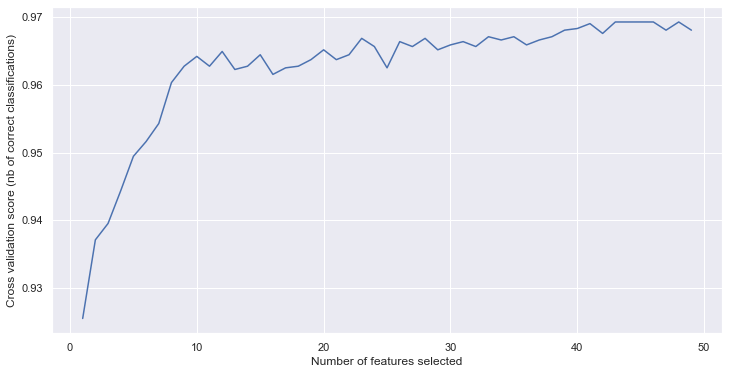

Accuracy: 0.9707
Precision: 0.9707
Recall: 0.9707
F1 Score: 0.9707
Cohen Kappa Score: 0.9413
Matthews Corrcoef: 0.9413
roc_auc_score: 0.9705278128950696
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       914
         1.0       0.96      0.98      0.97       858

    accuracy                           0.97      1772
   macro avg       0.97      0.97      0.97      1772
weighted avg       0.97      0.97      0.97      1772

Confusion Matrix:
 [[883  21]
 [ 31 837]]


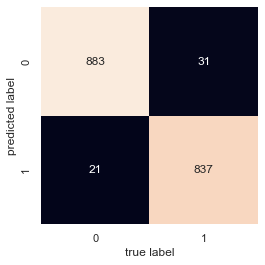

In [10]:
from sklearn.ensemble import RandomForestClassifier

estimator = estimator=RandomForestClassifier()
model = RandomForestClassifier(n_estimators=100, random_state=92116)

n_splits = 5
n_repeats = 5
rf_model = refcv_model(X_train, y_train, estimator, model, n_splits, n_repeats)
plot_results(rf_model[0])

<AxesSubplot:>

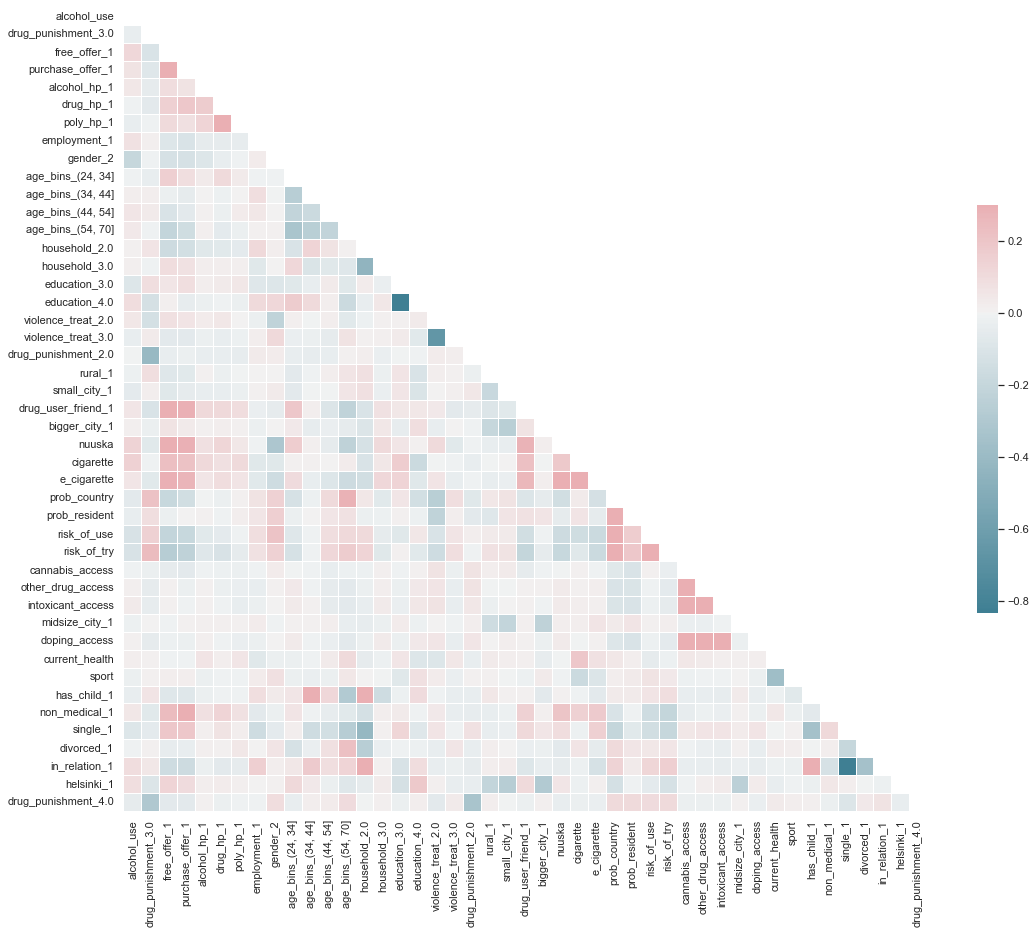

In [11]:
import seaborn as sns
# New Correlation Matrix
sns.set(style="white")

# Compute the correlation matrix
corr = data[rf_model[1]].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, )
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Model 2: sampling_strategy: not minority

In [12]:
# resample by adding samples to minority class using SMOTE
from collections import Counter
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

# 'not minority': resample all classes but the minority class;
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='not minority'))
X_oversamp, Y_over_samp = resample.fit_resample(X, y)



#split data train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_oversamp,
                                                    Y_over_samp,
                                                    test_size=0.3,
                                                    random_state = 10)



print(f"Class counts after resampling {Counter( Y_over_samp)}")

Class counts after resampling Counter({0.0: 2953, 1.0: 2953})


## 2.1. GradientBoostingClassifier

Optimal number of features : 31


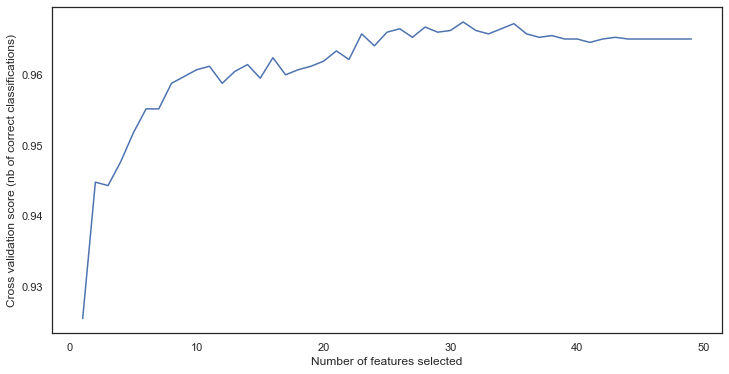

Accuracy: 0.9599
Precision: 0.9599
Recall: 0.9599
F1 Score: 0.9599
Cohen Kappa Score: 0.9198
Matthews Corrcoef: 0.9198
roc_auc_score: 0.9599042657314139
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       905
         1.0       0.96      0.96      0.96       867

    accuracy                           0.96      1772
   macro avg       0.96      0.96      0.96      1772
weighted avg       0.96      0.96      0.96      1772

Confusion Matrix:
 [[869  35]
 [ 36 832]]


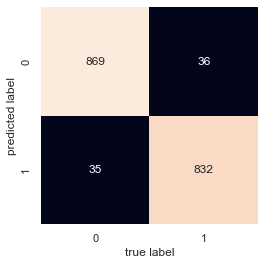

In [13]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

estimator = GradientBoostingClassifier()
model = GradientBoostingClassifier()
n_splits = 5
n_repeats = 5

gbc_model = refcv_model(X_train, y_train, estimator, model, n_splits, n_repeats)
plot_results(gbc_model[0])

## 2.2. RandomForestClassifier

Optimal number of features : 46


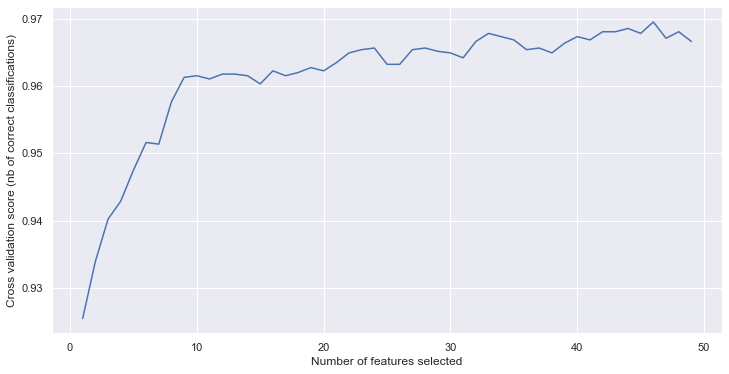

Accuracy: 0.9599
Precision: 0.9599
Recall: 0.9599
F1 Score: 0.9599
Cohen Kappa Score: 0.9198
Matthews Corrcoef: 0.9198
roc_auc_score: 0.9599042657314139
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       905
         1.0       0.96      0.96      0.96       867

    accuracy                           0.96      1772
   macro avg       0.96      0.96      0.96      1772
weighted avg       0.96      0.96      0.96      1772

Confusion Matrix:
 [[869  35]
 [ 36 832]]


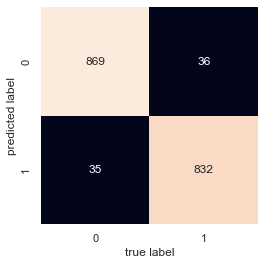

In [14]:
from sklearn.ensemble import RandomForestClassifier

estimator = estimator=RandomForestClassifier()
model = RandomForestClassifier(n_estimators=100, random_state=92116)

n_splits = 5
n_repeats = 5
rf_model = refcv_model(X_train, y_train, estimator, model, n_splits, n_repeats)
plot_results(gbc_model[0])

# Model 3: sampling_strategy: not majority

In [15]:
# resample by adding samples to minority class using SMOTE
from collections import Counter
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

# 'not majority': resample all classes but the majority class;
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='not majority'))
X_oversamp, Y_over_samp = resample.fit_resample(X, y)



#split data train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_oversamp,
                                                    Y_over_samp,
                                                    test_size=0.3,
                                                    random_state = 10)



print(f"Class counts after resampling {Counter( Y_over_samp)}")

Class counts after resampling Counter({0.0: 2953, 1.0: 2953})


# 3.1. GradientBoostingClassifier

Optimal number of features : 28


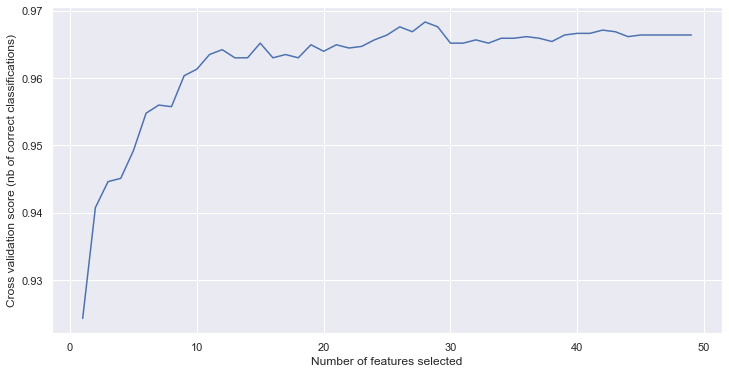

Accuracy: 0.9633
Precision: 0.9633
Recall: 0.9633
F1 Score: 0.9633
Cohen Kappa Score: 0.9266
Matthews Corrcoef: 0.9266
roc_auc_score: 0.9633146078871173
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       903
         1.0       0.96      0.96      0.96       869

    accuracy                           0.96      1772
   macro avg       0.96      0.96      0.96      1772
weighted avg       0.96      0.96      0.96      1772

Confusion Matrix:
 [[871  33]
 [ 32 836]]


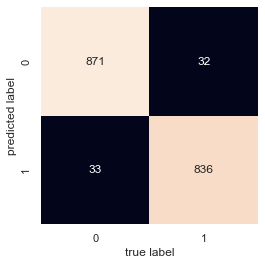

In [16]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

estimator = GradientBoostingClassifier()
model = GradientBoostingClassifier()
n_splits = 5
n_repeats = 5

gbc_model = refcv_model(X_train, y_train, estimator, model, n_splits, n_repeats)
plot_results(gbc_model[0])

## 3.2. RandomForestClassifier

Optimal number of features : 39


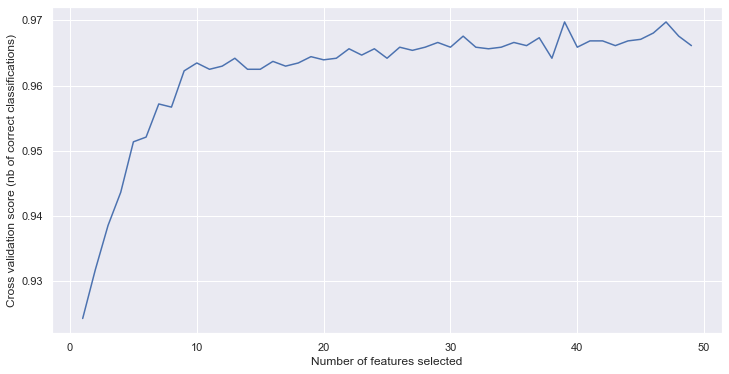

Accuracy: 0.9633
Precision: 0.9633
Recall: 0.9633
F1 Score: 0.9633
Cohen Kappa Score: 0.9266
Matthews Corrcoef: 0.9266
roc_auc_score: 0.9633146078871173
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       903
         1.0       0.96      0.96      0.96       869

    accuracy                           0.96      1772
   macro avg       0.96      0.96      0.96      1772
weighted avg       0.96      0.96      0.96      1772

Confusion Matrix:
 [[871  33]
 [ 32 836]]


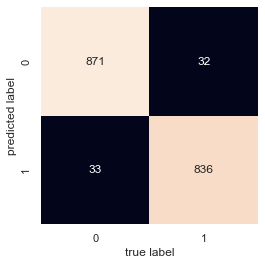

In [17]:
from sklearn.ensemble import RandomForestClassifier

estimator = estimator=RandomForestClassifier()
model = RandomForestClassifier(n_estimators=100, random_state=92116)

n_splits = 5
n_repeats = 5
rf_model = refcv_model(X_train, y_train, estimator, model, n_splits, n_repeats)
plot_results(gbc_model[0])

# Summary

During feature selection process, we used diffent methods and we obtained the best result with hybrit sampling technique. In the next section, I will use several classification method to determine the best features.